1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [76]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import numpy.random as npr
from numpy.random import uniform
from scipy.constants import physical_constants as pc
from scipy.constants import alpha,h,c
from scipy.integrate import quad, dblquad
from math import pi
npr.seed(42)

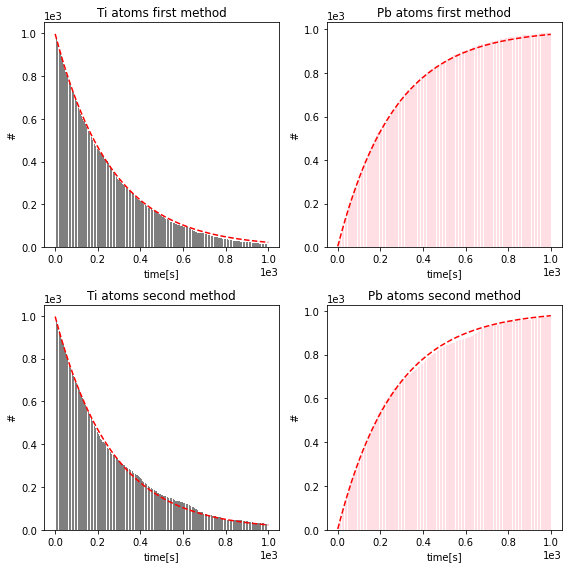

In [75]:
def p(t,tau = 3.052*60):
    return 1 - 2 **(-t/tau) 

tau = 3.052*60
N0 = 1000
time = np.arange(1,1000,1)

n_Ti = N0
n_Pb = 0
n_Ti_list = [N0]
n_Pb_list = [0]

u = npr.rand(N0)
z = npr.rand(N0)

for t in time:
    n_dec = (u <= p(t)).sum()
    n_Ti -= n_dec
    n_Pb += n_dec
    u = u[u > p(t)]
    n_Ti_list.append(n_Ti)
    n_Pb_list.append(n_Pb)

t_dec = -tau*np.log2(1 - z)

N_Ti = N0
N_Pb = 0
N_Ti_list = [N0]
N_Pb_list = [0]


for t in time:
    N_dec = (t_dec <= t).sum()
    N_Ti -= N_dec
    N_Pb += N_dec
    N_Ti_list.append(N_Ti)
    N_Pb_list.append(N_Pb)
    t_dec = t_dec[t_dec > t]
    

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols = 2, nrows = 2, figsize = (8,8))
ax1.bar([0,*time], n_Ti_list, color = 'black', alpha = 0.5)
ax1.plot(time, 1000*(1 - p(time)), linestyle = '--', c = 'red')
ax2.bar([0,*time], n_Pb_list, color = 'pink', alpha = 0.5)
ax2.plot(time, 1000*p(time), linestyle = '--', c = 'red')
ax3.bar([0,*time], N_Ti_list, color = 'black', alpha = 0.5)
ax3.plot(time, 1000*(1 - p(time)), linestyle = '--', c = 'red')
ax4.bar([0,*time], N_Pb_list, color = 'pink', alpha = 0.5)
ax4.plot(time, 1000*p(time), linestyle = '--', c = 'red')
ax1.set_xlabel('time[s]')
ax2.set_xlabel('time[s]')
ax3.set_xlabel('time[s]')
ax4.set_xlabel('time[s]')
ax1.set_ylabel('#')
ax2.set_ylabel('#')
ax3.set_ylabel('#')
ax4.set_ylabel('#')
ax1.ticklabel_format(axis = 'both', style = 'scientific', scilimits = (0,0))
ax2.ticklabel_format(axis = 'both', style = 'scientific', scilimits = (0,0))
ax3.ticklabel_format(axis = 'both', style = 'scientific', scilimits = (0,0))
ax4.ticklabel_format(axis = 'both', style = 'scientific', scilimits = (0,0))
ax1.title.set_text('Ti atoms first method')
ax2.title.set_text('Pb atoms first method')
ax3.title.set_text('Ti atoms second method')
ax4.title.set_text('Pb atoms second method')
plt.tight_layout()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [77]:
def ruth(b,Z = 79, E = 7.7): 
    return (2*Z*pc['Planck constant in eV/Hz'][0]*c*alpha * 1e-6)/(E*b) #Rutherford cross section in CGS

N = int(1e6)
z = npr.rand(N)

sig = pc['Bohr radius'][0]/100
b = np.sqrt(-2 * (sig**2) * np.log(1-z))
bb = (len(z[ruth(b = b)>=1])/N)*100

print('bouncing back percentage: %f'%(bb))
print('b limit =', np.amax(b[ruth(b=b) <= 1]))

bouncing back percentage: 5.927900
b limit = 2.728591078285713e-12


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [83]:
def f(x):
    return (np.sin(1/(x*(2-x) + 1e-30)))**2

N = 100000
y_range = npr.random(N)
x_range = npr.random(N) #the function is symmetric with respect of x = 1

i = 0
count = 0
for i in range(N):
    if y_range[i] <= f(x_range[i]):
        count += 1
I_montecarlo =  count *2/N

results = quad(f,0,1, limit = 1000, points = (0.)) #every built-in function I have tried fails on integrating
                                                   #this function properly

#I evaluate the error comparing the Montecarlo result with the quad one. 
print('I_quad = %f +- %f' %(2*results[0], 2*results[1]))

print('I_montecarlo = %f +- %f' %(I_montecarlo,abs(I_montecarlo-2*results[0])))

#Now I use the mean value method
I_mean_value = 2*f(x_range).sum()/N
print('I_mean_value = %f +- %f' %(I_mean_value, abs(I_mean_value - 2*results[0])))

I_quad = 1.451403 +- 0.000009
I_montecarlo = 1.447920 +- 0.003483
I_mean_value = 1.449274 +- 0.002128


<ipython-input-83-f7b66f6a6af3>:15: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  results = quad(f,0,1, limit = 1000, points = (0.)) #every built-in function I have tried fails on integrating


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [84]:
def f(x,y):
    if x**2 + y**2 <= 1: return 1
    else: return 0
    
def f10(x):
    if x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 + x[4]**2 + x[5]**2 + x[6]**2 + x[7]**2 + x[8]**2 + x[9]**2 <= 1 : return 1
    else: return 0

#using built_in functions
I_dblquad,dI_dblquad = dblquad(f,-1,1,lambda x: -np.sqrt(1 - x**2), lambda x: +np.sqrt(1 - x**2))
print('I_quad = %f +- %f' %(I_dblquad,dI_dblquad))

#Now using Montecarlo
N = 100000
count = 0
for i in range(N):
    count += f(npr.random(),npr.random())

I_montecarlo2d = 4*count/N

print('I_montecarlo2d = %f +- %f'%(I_montecarlo2d,abs(I_montecarlo2d - I_dblquad)))

#Now computing the 10D sphere iper-volume
count = 0
for i in range(N):
        count += f10(npr.random(10)) 

V_ipersphere = pi**5/120 #the exact value of the iper-volume of a 10-D sphere

I_montecarlo10d =  2**10 * count/N
print('I_montecarlo10d = %f +- %f'%(I_montecarlo10d, abs(I_montecarlo10d - V_ipersphere)))

I_quad = 3.141593 +- 0.000000
I_montecarlo2d = 3.144880 +- 0.003287
I_montecarlo10d = 2.385920 +- 0.164244


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [85]:
def f(x):
    return (x)**(-1/2)/(np.exp(x) + 1)

def w(x):
    return 1/(np.sqrt(x))

N = 1000
x = beta(1/2,1).rvs(size = N)
I = (2/N)*(f(x)/w(x)).sum()

print('Integral:',I)

#the main problem is sampling w near the origin.

Integral: 0.8405531213483566
